Optimización de Blancos de Exploración en Distritos Cubiertos: Usando como referencia Caso Domeyko

Este cuaderno técnico evalúa estrategias de Machine Learning para la detección de pórfidos de Cobre-Oro ocultos bajo gravas post-minerales ("Atacama Gravels") en el distrito Domeyko.

El estudio simula y compara dos enfoques metodológicos para resolver el problema del "ruido geoquímico" y los falsos positivos magnéticos:

1. Enfoque Convencional (Baseline):

Datos: Geoquímica de suelos y Magnetometría RTP cruda.

Modelo: Clasificador Random Forest.

Hipótesis: La coincidencia espacial simple entre anomalías magnéticas y geoquímicas es suficiente para definir un blanco.

2. Enfoque Estructural:

Datos: Integración del modelo estructural regional descrito en el PFS 2025 de Hot Chili como ejemplos (Intersección de fallas NNE y WNW).

Feature Engineering: Cálculo de vectores de proximidad a fallas y textura magnética (rugosidad).

Modelo: Clasificador Gradient Boosting (XGBoost).

Hipótesis: Incorporar el control estructural como variable matemática reduce los falsos positivos generados por intrusivos estériles.

Objetivo del Notebook Demostrar cuantitativamente cómo la incorporación de conocimiento geológico (fallas y texturas) dentro de un algoritmo de ML mejora la precisión del targeting en escenarios de exploración. Este cuaderno es **basíco**, solo **ejemplo** de metodología, pero se pueden añadir muchas más variables.

---

Referencia de un problema: Hot Chili Limited. (2025). Hot Chili Announces PFS & Maiden Ore Reserve for the Costa Fuego Cu-Au Project. Anuncio ASX del 27 de marzo de 2025

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Configuración visual
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (15, 5)

def generar_mapa_domeyko(n_points=3000): # Aumenté a 3000 puntos para mejor resolución
    np.random.seed(42)

    # CREAR EL TERRENO (Grid 10km x 10km)
    x = np.random.uniform(0, 10000, n_points)
    y = np.random.uniform(0, 10000, n_points)

    # DEFINIR LOS BLANCOS (TARGETS)
    targets = [
        {'x': 3000, 'y': 7000, 'type': 'La Verde (Giant)', 'mag_strength': 1.0, 'chem_leak': 0.8},
        {'x': 7000, 'y': 3000, 'type': 'Pórfido Ciego (Deep)', 'mag_strength': 0.7, 'chem_leak': 0.3},
        {'x': 5000, 'y': 5000, 'type': 'Intrusivo Estéril', 'mag_strength': 0.9, 'chem_leak': 0.05}
    ]

    # GENERAR SEÑALES (Mag y Geoquímica)
    mag_signal = np.random.normal(0, 5, n_points) # Ruido base
    cu_ppm = np.random.lognormal(2, 0.5, n_points)
    au_ppb = np.random.lognormal(1, 0.5, n_points)
    cover_thickness = np.random.uniform(10, 100, n_points)

    # Array para guardar si es mineral real o no (Ground Truth)
    is_ore_array = np.zeros(n_points)

    for t in targets:
        dist = np.sqrt((x - t['x'])**2 + (y - t['y'])**2)

        # Señal Magnética (Penetra todo)
        mag_signal += t['mag_strength'] * 1000 * np.exp(-dist/800)

        # Señal Geoquímica (Bloqueada por cobertura)
        signal = t['chem_leak'] * 500 * np.exp(-dist/400) * (1 / (cover_thickness/10))
        cu_ppm += signal
        au_ppb += signal * 0.5

        # Definir si el punto es "Ore" (Radio 600m y NO es estéril)
        if t['type'] != 'Intrusivo Estéril':
            # Marcamos con 1 los puntos cercanos a un target fértil
            is_ore_array = np.where(dist < 600, 1, is_ore_array)

    # Crear DataFrame
    df = pd.DataFrame({
        'Este': x, 'Norte': y,
        'Mag_RTP': mag_signal,
        'Cu_ppm': cu_ppm,
        'Au_ppb': au_ppb,
        'Cover_m': cover_thickness,
        'Is_Ore': is_ore_array # Usamos el array corregido
    })

    # Añadir ruido
    df['Cu_ppm'] *= np.random.uniform(0.9, 1.1, len(df))

    return df, targets

# Ejecutar generación
df_domeyko, real_targets = generar_mapa_domeyko()

# VERIFICACIÓN DE SEGURIDAD
conteo = df_domeyko['Is_Ore'].value_counts()
print(f"Puntos Totales: {len(df_domeyko)}")
print(f"Puntos de Mineral (Clase 1): {conteo.get(1, 0)}")
print(f"Puntos Estériles (Clase 0): {conteo.get(0, 0)}")

if conteo.get(1, 0) < 10:
    print("ALERTA: Muy pocos puntos de mineral. Ejecuta de nuevo la celda.")
else:
    print("Datos listos para Machine Learning.")

# Guardar los datos generados para el módulo de Teledetección
print("Exportando datos para análisis satelital...")
df_real.to_csv('domeyko_simulated_data.csv', index=False)

# Guardar los targets (como es una lista de dicts, usamos pickle o pandas)
pd.DataFrame(targets_real).to_csv('domeyko_targets.csv', index=False)
print("¡Datos exportados con éxito!")

Puntos Totales: 3000
Puntos de Mineral (Clase 1): 77
Puntos Estériles (Clase 0): 2923
Datos listos para Machine Learning.
Exportando datos para análisis satelital...
¡Datos exportados con éxito!


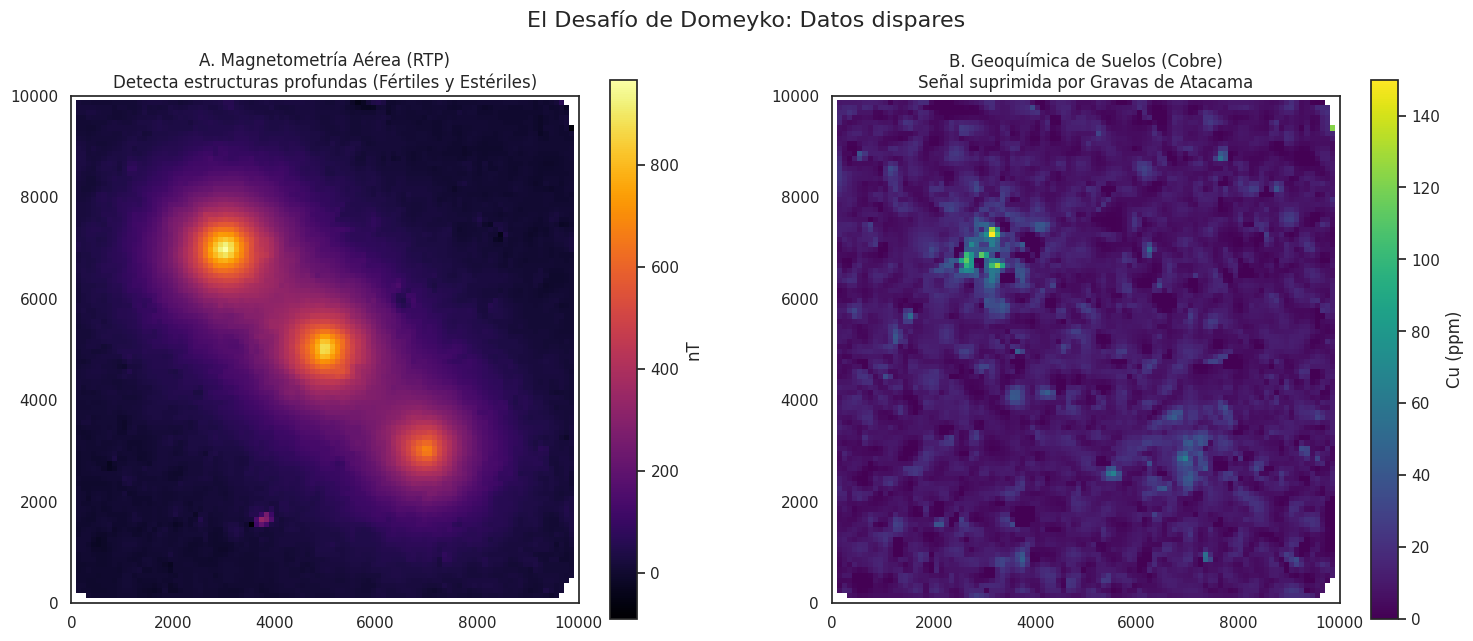

In [16]:
def plot_exploration_maps(df):
    # Interpolación para crear mapas suaves (Griddata)
    grid_x, grid_y = np.mgrid[0:10000:100j, 0:10000:100j]

    # Mapa 1: Magnetometría (Lo que ve la geofísica)
    grid_mag = griddata((df['Este'], df['Norte']), df['Mag_RTP'], (grid_x, grid_y), method='cubic')

    # Mapa 2: Cobre en Suelos (Lo que ve la geoquímica - Muy ruidoso por la grava)
    grid_cu = griddata((df['Este'], df['Norte']), df['Cu_ppm'], (grid_x, grid_y), method='cubic')

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plot Mag
    im1 = axes[0].imshow(grid_mag.T, extent=(0,10000,0,10000), origin='lower', cmap='inferno')
    axes[0].set_title('A. Magnetometría Aérea (RTP)\nDetecta estructuras profundas (Fértiles y Estériles)')
    plt.colorbar(im1, ax=axes[0], label='nT')

    # Plot Cu
    im2 = axes[1].imshow(grid_cu.T, extent=(0,10000,0,10000), origin='lower', cmap='viridis', vmin=0, vmax=150)
    axes[1].set_title('B. Geoquímica de Suelos (Cobre)\nSeñal suprimida por Gravas de Atacama')
    plt.colorbar(im2, ax=axes[1], label='Cu (ppm)')

    plt.suptitle("El Desafío de Domeyko: Datos dispares", fontsize=16)
    plt.show()

plot_exploration_maps(df_domeyko)

In [17]:
# Feature Engineering (Ingeniería de Características)
# Creamos ratios que ayudan al modelo a "ver" a través del ruido
df_model = df_domeyko.copy()

# Ratio Mag/Cu: Ayuda a diferenciar intrusivos estériles (Alto Mag, Bajo Cu) de fértiles
df_model['Mag_Cu_Ratio'] = df_model['Mag_RTP'] / (df_model['Cu_ppm'] + 1)

# Normalización
scaler = MinMaxScaler()
features = ['Mag_RTP', 'Cu_ppm', 'Au_ppb', 'Mag_Cu_Ratio']
X = scaler.fit_transform(df_model[features])
y = df_model['Is_Ore']

# Entrenar Modelo (Random Forest)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predicción sobre todo el Grid
df_domeyko['Probabilidad_Porfido'] = rf_model.predict_proba(X)[:, 1]

# Métricas
print("--- Rendimiento del Modelo ---")
print(classification_report(y_test, rf_model.predict(X_test)))

# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=features)
print("\nVariables más importantes para detectar pórfidos ciegos:")
print(importances.sort_values(ascending=False))

--- Rendimiento del Modelo ---
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       880
         1.0       0.68      0.65      0.67        20

    accuracy                           0.99       900
   macro avg       0.84      0.82      0.83       900
weighted avg       0.99      0.99      0.99       900


Variables más importantes para detectar pórfidos ciegos:
Mag_RTP         0.590356
Au_ppb          0.213459
Cu_ppm          0.168847
Mag_Cu_Ratio    0.027338
dtype: float64


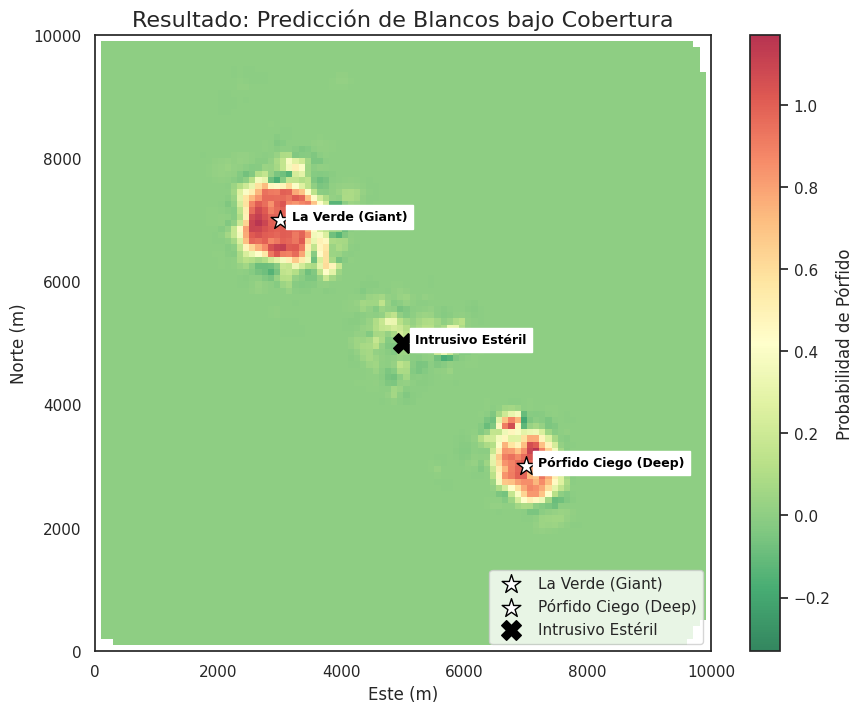

In [18]:
def plot_model_results(df, targets):
    grid_x, grid_y = np.mgrid[0:10000:100j, 0:10000:100j]
    grid_prob = griddata((df['Este'], df['Norte']), df['Probabilidad_Porfido'], (grid_x, grid_y), method='cubic')

    plt.figure(figsize=(10, 8))

    # Plot Probabilidad
    plt.imshow(grid_prob.T, extent=(0,10000,0,10000), origin='lower', cmap='RdYlGn_r', alpha=0.8)
    plt.colorbar(label='Probabilidad de Pórfido')

    # Marcar los objetivos reales (Ground Truth)
    for t in targets:
        marker = '*' if 'Estéril' not in t['type'] else 'X'
        color = 'white' if 'Estéril' not in t['type'] else 'black'
        plt.scatter(t['x'], t['y'], s=200, c=color, marker=marker, edgecolors='black', label=t['type'])
        plt.text(t['x']+200, t['y'], t['type'], color='black', fontweight='bold', fontsize=9, backgroundcolor='white')

    plt.title("Resultado: Predicción de Blancos bajo Cobertura", fontsize=16)
    plt.xlabel("Este (m)")
    plt.ylabel("Norte (m)")
    plt.legend(loc='lower right')
    plt.show()

plot_model_results(df_domeyko, real_targets)

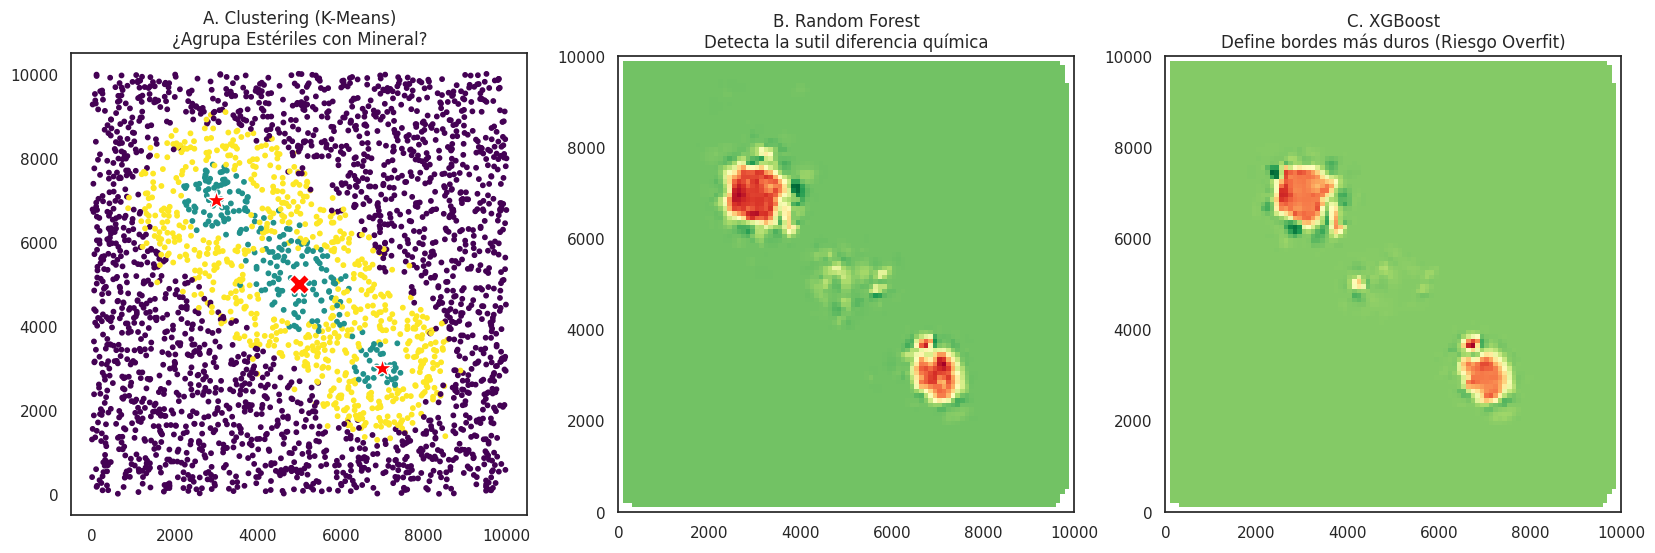

In [8]:
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier

# COMPARACIÓN DE MODELOS

# K-MEANS (No Supervisado - "El Explorador Ciego")
# Le pedimos 3 grupos, esperando que separe: Fondo, Estéril, Mineral
kmeans = KMeans(n_clusters=3, random_state=42)
df_domeyko['Cluster_KMeans'] = kmeans.fit_predict(X)

# XGBoost (Boosting - "El Ferrari Sensible")
xgb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
df_domeyko['Prob_XGB'] = xgb_model.predict_proba(X)[:, 1]

# VISUALIZACIÓN COMPARATIVA
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico 1: K-Means (Falla al discriminar)
scatter1 = axes[0].scatter(df_domeyko['Este'], df_domeyko['Norte'], c=df_domeyko['Cluster_KMeans'], cmap='viridis', s=10)
axes[0].set_title('A. Clustering (K-Means)\n¿Agrupa Estériles con Mineral?', fontsize=12)
# Marcar targets reales
for t in real_targets:
    marker = 'X' if 'Estéril' in t['type'] else '*'
    axes[0].plot(t['x'], t['y'], marker, markersize=15, markeredgecolor='white', color='red')

# Gráfico 2: Random Forest (Balanceado?)
grid_x, grid_y = np.mgrid[0:10000:100j, 0:10000:100j]
grid_rf = griddata((df_domeyko['Este'], df_domeyko['Norte']), df_domeyko['Probabilidad_Porfido'], (grid_x, grid_y), method='cubic')
axes[1].imshow(grid_rf.T, extent=(0,10000,0,10000), origin='lower', cmap='RdYlGn_r')
axes[1].set_title('B. Random Forest\nDetecta la sutil diferencia química', fontsize=12)

# Gráfico 3: XGBoost (Más agresivo)
grid_xgb = griddata((df_domeyko['Este'], df_domeyko['Norte']), df_domeyko['Prob_XGB'], (grid_x, grid_y), method='cubic')
axes[2].imshow(grid_xgb.T, extent=(0,10000,0,10000), origin='lower', cmap='RdYlGn_r')
axes[2].set_title('C. XGBoost\nDefine bordes más duros (Riesgo Overfit)', fontsize=12)

plt.show()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import RobustScaler

# Configuración visual
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = (16, 6)

def generar_sistema_domeyko_realista(n_points=5000):
    np.random.seed(42) # Semilla fija para reproducibilidad

    # GRID ESPACIAL (10km x 10km)
    x = np.random.uniform(0, 10000, n_points)
    y = np.random.uniform(0, 10000, n_points)
    points = np.column_stack((x, y))

    # DEFINIR ESTRUCTURAS REALES (Basado en PFS Hot Chili)

    # Falla A: Sistema Productora/Rancho (Tendencia NNE - Norte Noreste)
    # Cruza el mapa verticalmente (aprox 15 grados)
    # Punto inicio (2000, 0) -> Punto fin (4500, 10000)
    falla_nne_start = np.array([2000, 0])
    falla_nne_end = np.array([4500, 10000])

    # Falla B: Corredor Serrano/Cortadera (Tendencia WNW - Oeste Noroeste)
    # Cruza transversalmente (aprox 110-120 grados)
    # Punto inicio (0, 8000) -> Punto fin (10000, 4000)
    falla_wnw_start = np.array([0, 8000])
    falla_wnw_end = np.array([10000, 4000])

    # Función distancia punto-línea
    def dist_to_segment(p, a, b):
        ab = b - a
        ap = p - a
        t = np.dot(ap, ab) / np.dot(ab, ab)
        t = np.clip(t, 0, 1)
        closest = a + t * ab
        return np.linalg.norm(p - closest)

    dist_falla_nne = np.array([dist_to_segment(p, falla_nne_start, falla_nne_end) for p in points])
    dist_falla_wnw = np.array([dist_to_segment(p, falla_wnw_start, falla_wnw_end) for p in points])

    # La variable "Distancia a Falla" será la menor de las dos
    dist_min_falla = np.minimum(dist_falla_nne, dist_falla_wnw)

    # DEFINIR BLANCOS (Targets Geológicos)
    # Ubicados estratégicamente según el modelo estructural andino
    targets = [
        # Target 1: La Verde (En la intersección de las dos fallas - El mejor blanco)
        {'x': 3200, 'y': 6800, 'type': 'La Verde (Intersección)', 'mag': 1.0, 'chem': 0.9, 'aster': 0.9},

        # Target 2: Pórfido Ciego (A lo largo del corredor Serrano WNW, profundo)
        {'x': 7500, 'y': 5000, 'type': 'Pórfido Ciego (WNW)', 'mag': 0.85, 'chem': 0.25, 'aster': 0.3},

        # Target 3: Falso Positivo (Intrusivo magnético pero SIN control estructural claro)
        {'x': 8000, 'y': 8000, 'type': 'Intrusivo Estéril (Aislado)', 'mag': 0.95, 'chem': 0.05, 'aster': 0.1}
    ]

    # GENERAR SEÑALES SINTÉTICAS
    mag_signal = np.random.normal(0, 10, n_points)
    cu_ppm = np.random.lognormal(2.5, 0.6, n_points)
    aster_index = np.random.beta(2, 5, n_points)
    cover = np.random.uniform(10, 120, n_points) # Cobertura de gravas

    is_ore = np.zeros(n_points)

    for t in targets:
        dist = np.sqrt((x - t['x'])**2 + (y - t['y'])**2)

        # Mag: Señal fuerte y amplia (profunda)
        mag_signal += t['mag'] * 1500 * np.exp(-dist/900)

        # Cu: Controlado por estructura WNW (Serrano) preferentemente
        # El "Leakage" es mayor si está cerca de la falla WNW
        structural_perm = np.exp(-dist_falla_wnw/600) + 0.1

        chem_signal = t['chem'] * 800 * np.exp(-dist/500) * structural_perm / (cover/15)
        cu_ppm += chem_signal

        # ASTER: Alteración
        aster_signal = t['aster'] * 0.8 * np.exp(-dist/700)
        aster_index = np.clip(aster_index + aster_signal, 0, 1)

        if 'Estéril' not in t['type']:
            is_ore = np.where(dist < 600, 1, is_ore)

    # DATAFRAME FINAL
    df = pd.DataFrame({
        'Este': x, 'Norte': y,
        'Mag_RTP': mag_signal,
        'Cu_ppm': cu_ppm,
        'ASTER_Phyllic': aster_index,
        'Dist_Falla_NNE': dist_falla_nne, # Guardamos ambas distancias
        'Dist_Falla_WNW': dist_falla_wnw,
        'Dist_Min_Falla': dist_min_falla,
        'Cover_Depth': cover,
        'Target': is_ore
    })

    return df, targets, (falla_nne_start, falla_nne_end), (falla_wnw_start, falla_wnw_end)

# Generar y Verificar
df_real, targets_real, line_nne, line_wnw = generar_sistema_domeyko_realista()
print(f"Sistema Estructural Realista Generado.")
print(f"Muestras de Mineral: {df_real['Target'].sum()}")

Sistema Estructural Realista Generado.
Muestras de Mineral: 111.0


In [10]:
# Si la variable 'df_real' no existe,Celda 1 de nuevo.

def engineering_geologico(df):
    data = df.copy()

    # TEXTURA MAGNÉTICA (Rugosidad Local)
    # Buscamos anomalías magnéticas "rugosas" típicas de intrusivos vs "suaves" de flujos
    tree = cKDTree(data[['Este', 'Norte']])
    dists, indexes = tree.query(data[['Este', 'Norte']], k=10)

    # Calcular la desviación estándar del Mag en los 10 vecinos más cercanos
    local_mag_std = [np.std(data.iloc[idx]['Mag_RTP']) for idx in indexes]
    data['Mag_Texture'] = local_mag_std

    # RATIOS AVANZADOS
    # "Potencial Estructural": Cu alto vale más si está cerca de una falla (Leakage)
    # Usamos 'Dist_Min_Falla' que viene del nuevo modelo estructural
    data['Cu_Struct_Score'] = data['Cu_ppm'] / (data['Dist_Min_Falla'] + 100)

    # "Índice de Intrusivo": Coincidencia de Alto Magnetismo y Alteración
    data['Porphyry_Index'] = data['Mag_RTP'] * data['ASTER_Phyllic']

    return data

# Ejecutar con el dataframe correcto (df_real)
if 'df_real' in globals():
    df_final = engineering_geologico(df_real)
    print("Ingeniería de Características completada exitosamente.")
    print("Nuevas Variables Generadas: Mag_Texture, Cu_Struct_Score, Porphyry_Index")
    display(df_final.head())
else:
    print("ERROR: No se encontró 'df_real'. Por favor, ejecuta la Celda 1 (Generación de Sistema Realista) primero.")

Ingeniería de Características completada exitosamente.
Nuevas Variables Generadas: Mag_Texture, Cu_Struct_Score, Porphyry_Index


,Este,Norte,Mag_RTP,Cu_ppm,ASTER_Phyllic,Dist_Falla_NNE,Dist_Falla_WNW,Dist_Min_Falla,Cover_Depth,Target,Mag_Texture,Cu_Struct_Score,Porphyry_Index
0,3745.401188,3936.355203,62.678049,8.277566,0.216045,738.581503,2381.992394,738.581503,100.488832,0.0,12.737874,0.009871,13.541275
1,9507.143064,4734.356594,150.322969,11.757179,0.330087,6134.748406,498.790509,498.790509,99.387960,0.0,14.053253,0.019635,49.619620
2,7319.939418,8545.473932,579.889500,29.813654,0.312818,3088.517466,3225.017083,3088.517466,55.885903,0.0,58.040937,0.009350,181.400085
3,5986.584842,3400.043861,115.336880,16.595083,0.242516,3042.923623,2047.590261,2047.590261,79.943065,0.0,22.548159,0.007727,27.970984
4,1560.186404,8696.496848,105.258896,5.359024,0.551060,2535.892160,1226.119773,1226.119773,21.311217,0.0,13.735562,0.004041,58.003956


--- REPORTE DE CLASIFICACIÓN DEEPSIGHT 3.0 ---
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1474
         1.0       0.92      0.92      0.92        26

    accuracy                           1.00      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       1.00      1.00      1.00      1500

ROC-AUC Score: 0.9607


/tmp/ipython-input-3619001587.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


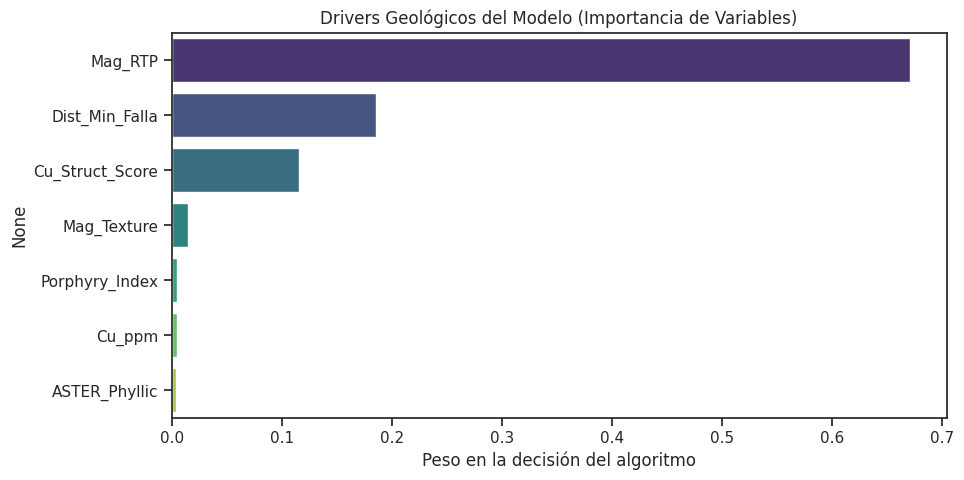

In [11]:
#PREPARACIÓN DE DATOS
# Lista actualizada de variables predictoras
features = ['Mag_RTP', 'Cu_ppm', 'ASTER_Phyllic', 'Dist_Min_Falla',
            'Mag_Texture', 'Cu_Struct_Score', 'Porphyry_Index']

X = df_final[features]
y = df_final['Target']

# Escalado Robusto (Ideal para geoquímica con valores extremos)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ENTRENAMIENTO (Gradient Boosting)
model_gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model_gb.fit(X_train, y_train)

# PREDICCIÓN Y EVALUACIÓN
y_pred = model_gb.predict(X_test)
# Guardamos la probabilidad de "Éxito" (Clase 1)
df_final['Prob_Discovery'] = model_gb.predict_proba(X_scaled)[:, 1]

print("--- REPORTE DE CLASIFICACIÓN DEEPSIGHT 3.0 ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, model_gb.predict_proba(X_test)[:, 1]):.4f}")

# GRÁFICO DE IMPORTANCIA (¿Qué variables mandan?)
plt.figure(figsize=(10, 5))
feat_imp = pd.Series(model_gb.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title("Drivers Geológicos del Modelo (Importancia de Variables)")
plt.xlabel("Peso en la decisión del algoritmo")
plt.show()

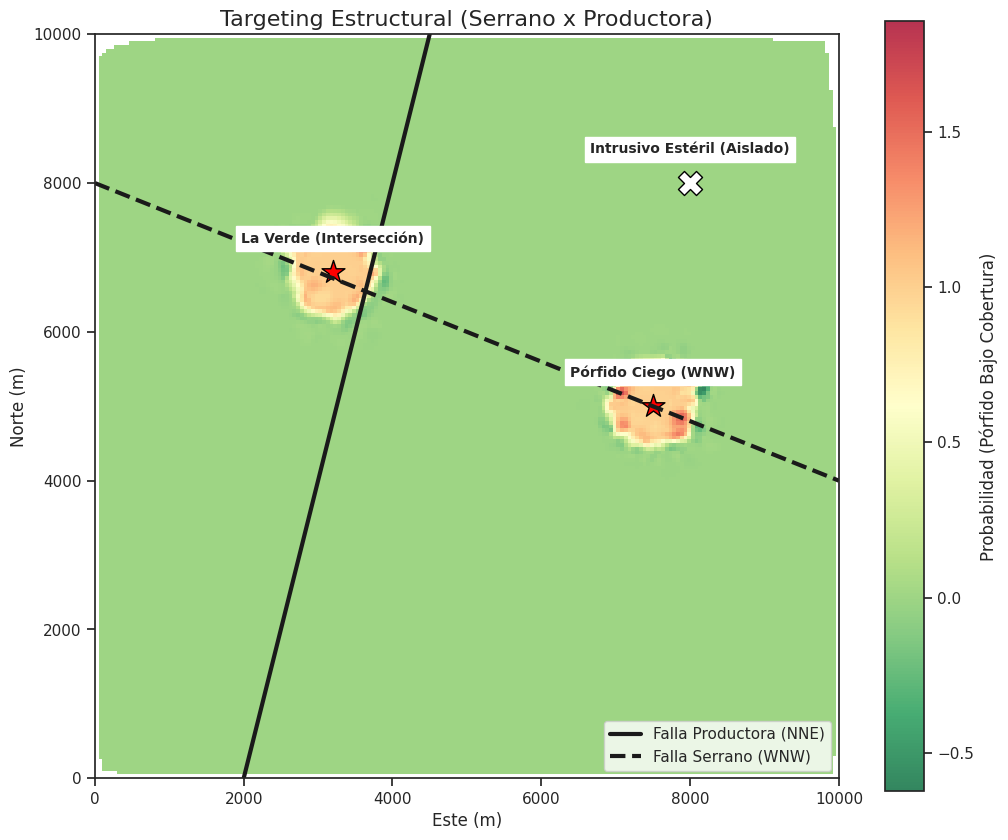

In [12]:
def plot_advanced_targeting_real(df, targets, l_nne, l_wnw):
    grid_x, grid_y = np.mgrid[0:10000:200j, 0:10000:200j]
    grid_prob = griddata((df['Este'], df['Norte']), df['Prob_Discovery'], (grid_x, grid_y), method='cubic')

    plt.figure(figsize=(12, 10))

    # Mapa Probabilidad
    plt.imshow(grid_prob.T, extent=(0,10000,0,10000), origin='lower', cmap='RdYlGn_r', alpha=0.8)
    plt.colorbar(label='Probabilidad (Pórfido Bajo Cobertura)')

    # DIBUJAR FALLAS REALES (PFS Report)
    # Falla Productora (NNE)
    plt.plot([l_nne[0][0], l_nne[1][0]], [l_nne[0][1], l_nne[1][1]], 'k-', linewidth=3, label='Falla Productora (NNE)')
    # Falla Serrano (WNW)
    plt.plot([l_wnw[0][0], l_wnw[1][0]], [l_wnw[0][1], l_wnw[1][1]], 'k--', linewidth=3, label='Falla Serrano (WNW)')

    # Targets
    for t in targets:
        marker = 'X' if 'Estéril' in t['type'] else '*'
        color = 'white' if 'Estéril' in t['type'] else 'red'
        # Ajuste de etiqueta para que no se superponga
        offset_y = 400 if t['y'] < 9000 else -800
        plt.scatter(t['x'], t['y'], s=300, c=color, marker=marker, edgecolors='black')
        plt.text(t['x'], t['y']+offset_y, t['type'], fontsize=10, fontweight='bold', ha='center', backgroundcolor='white')

    plt.title("Targeting Estructural (Serrano x Productora)", fontsize=16)
    plt.legend(loc='lower right')
    plt.xlabel("Este (m)")
    plt.ylabel("Norte (m)")
    plt.show()

plot_advanced_targeting_real(df_final, targets_real, line_nne, line_wnw)